In [2]:
# --- Setup and Libraries ---
import os, glob, random
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm
import opensmile
import soundfile as sf
import seaborn as sns
import matplotlib.pyplot as plt

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Imbalance handling
from imblearn.over_sampling import SMOTE

# Deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


In [4]:
# --- Dataset Paths ---
data_paths = {
    "Healthy": r"C:\Users\USER\OneDrive\Desktop\Code\s3\Speech project\New_speech_dataset\Healthy",
    "Parkinson": r"C:\Users\USER\OneDrive\Desktop\Code\s3\Speech project\New_speech_dataset\parkinson"
}

# --- Tasks to include ---
required_tasks = ["B1", "B2", "FB1",
                  "VA1", "VA2", "VE1", "VE2", "VI1", "VI2",
                  "VO1", "VO2", "VU1", "VU2"]


In [6]:
# --- Collect files ---
paths = {"healthy": [], "parkinson": []}
for group, path in data_paths.items():
    all_group_files = glob.glob(os.path.join(path, '**', '*.wav'), recursive=True)
    filtered_files = [f for f in all_group_files if any(task in os.path.basename(f).upper() for task in required_tasks)]
    if "Healthy" in group:
        paths["healthy"].extend(filtered_files)
    elif "Parkinson" in group:
        paths["parkinson"].extend(filtered_files)

all_files = paths["healthy"] + paths["parkinson"]
print("Total audio files found:", len(all_files))


Total audio files found: 585


In [8]:
def preprocess_audio(file_path, target_sr=16000):
    try:
        y, sr = librosa.load(file_path, sr=None, mono=True)
        if sr != target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            sr = target_sr
        y = librosa.util.normalize(y)
        y, _ = librosa.effects.trim(y)
        sf.write(file_path, y, sr)
        return file_path
    except:
        return None

# Apply preprocessing
all_files_preprocessed = []
for f in tqdm(all_files, desc="Preprocessing audio files"):
    processed_file = preprocess_audio(f)
    if processed_file:
        all_files_preprocessed.append(processed_file)

print("Preprocessing complete! Total:", len(all_files_preprocessed))


Preprocessing audio files:   0%|                                                               | 0/585 [00:00<?, ?it/s]D:\jupyter\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
Preprocessing audio files: 100%|█████████████████████████████████████████████████████| 585/585 [00:37<00:00, 15.69it/s]

Preprocessing complete! Total: 585


File: C:\Users\USER\OneDrive\Desktop\Code\s3\Speech project\New_speech_dataset\Healthy\AGNESE P\B1APGANRET55F170320171104.wav
Duration (sec): 101.35 | Sampling rate: 16000


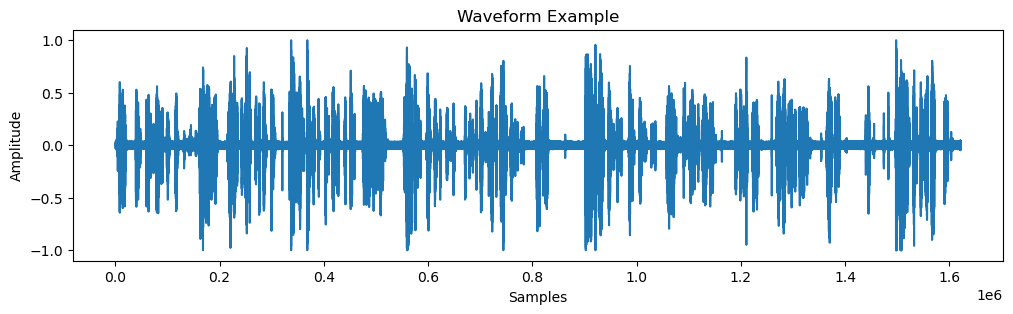

In [10]:
sample_file = all_files_preprocessed[0]
y, sr = librosa.load(sample_file, sr=None)

print("File:", sample_file)
print("Duration (sec):", round(len(y)/sr, 2), "| Sampling rate:", sr)

plt.figure(figsize=(12,3))
plt.plot(y)
plt.title("Waveform Example")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


In [12]:
all_files_preprocessed_dict = {
    "Healthy": [f for f in all_files_preprocessed if "Healthy" in f or "healthy" in f],
    "Parkinson": [f for f in all_files_preprocessed if "Parkinson" in f or "parkinson" in f]
}


In [14]:
# --- Linear Feature Extraction using OpenSMILE ---
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)

features_list, labels_list, files_list = [], [], []
label_map = {"Healthy": 0, "Parkinson": 1}

for group, file_list in all_files_preprocessed_dict.items():
    for f in tqdm(file_list, desc=f"Processing {group}"):
        try:
            feat = smile.process_file(f).values.flatten()
            features_list.append(feat)
            labels_list.append(label_map[group])
            files_list.append(f)
        except Exception as e:
            print(f"Error processing {f}: {e}")

feature_names = smile.feature_names
df_linear = pd.DataFrame(features_list, columns=feature_names)
df_linear["label"] = labels_list
df_linear["filename"] = files_list

print("Linear feature extraction complete:", df_linear.shape)
df_linear["label"].value_counts()


Processing Parkinson: 100%|██████████████████████████████████████████████████████████| 312/312 [07:36<00:00,  1.46s/it]


Linear feature extraction complete: (585, 6375)


label
1    312
0    273
Name: count, dtype: int64

In [16]:
X_lin = df_linear.drop(columns=["label", "filename"])
y_lin = df_linear["label"]

scaler_lin = StandardScaler()
X_lin_scaled = scaler_lin.fit_transform(X_lin)

selector_lin = VarianceThreshold(threshold=0.01)
X_lin_reduced = selector_lin.fit_transform(X_lin_scaled)

print("Linear features reduced from", X_lin.shape[1], "to", X_lin_reduced.shape[1])


Linear features reduced from 6373 to 6373


In [18]:
df_linear['participant'] = df_linear['filename'].apply(lambda x: x.split(os.sep)[-2])

participants = {
    "Healthy": df_linear[df_linear['label']==0]['participant'].unique().tolist(),
    "Parkinson": df_linear[df_linear['label']==1]['participant'].unique().tolist()
}

train_participants, test_participants = [], []
for group, plist in participants.items():
    random.seed(42)
    random.shuffle(plist)
    split = int(0.8 * len(plist))
    train_participants += plist[:split]
    test_participants += plist[split:]

train_mask = df_linear['participant'].isin(train_participants)
test_mask = df_linear['participant'].isin(test_participants)

X_train_lin, X_test_lin = X_lin_reduced[train_mask], X_lin_reduced[test_mask]
y_train_lin, y_test_lin = y_lin[train_mask], y_lin[test_mask]

print("Train samples:", len(y_train_lin), "| Test samples:", len(y_test_lin))


Train samples: 455 | Test samples: 130


In [20]:
from scipy.stats import entropy

def extract_nonlinear_features(y, sr=16000):
    feats = {}
    try:
        y = y.astype(float)
        n = len(y)
        hist, _ = np.histogram(y, bins=100, density=True)
        feats["shannon_entropy"] = entropy(hist + 1e-8)

        psd = np.abs(np.fft.fft(y))**2
        psd_norm = psd / np.sum(psd)
        feats["spectral_entropy"] = entropy(psd_norm + 1e-8)

        diff1 = np.diff(y)
        diff2 = np.diff(diff1)
        var_y, var_diff1, var_diff2 = np.var(y), np.var(diff1), np.var(diff2)
        feats["hjorth_mobility"] = np.sqrt(var_diff1 / (var_y + 1e-8))
        feats["hjorth_complexity"] = np.sqrt(var_diff2 / (var_diff1 + 1e-8)) / (feats["hjorth_mobility"] + 1e-8)

        N_delta = np.sum(diff1[1:] * diff1[:-1] < 0)
        feats["petrosian_fd"] = np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * N_delta + 1e-8)))

        L = np.sum(np.sqrt(1 + diff1**2))
        feats["sevcik_fd"] = L / (2*(n-1))

        feats["nldfd"] = feats["petrosian_fd"]
        feats["temporal_skewness"] = pd.Series(y).skew()
        feats["temporal_kurtosis"] = pd.Series(y).kurt()

        return feats
    except Exception as e:
        print("Error:", e)
        return None


In [22]:
features_list, labels_list, files_list = [], [], []
label_map = {"Healthy": 0, "Parkinson": 1}

for group, file_list in all_files_preprocessed_dict.items():
    for f in tqdm(file_list, desc=f"Processing {group}"):
        y, sr = librosa.load(f, sr=16000)
        feats = extract_nonlinear_features(y, sr)
        if feats:
            features_list.append(feats)
            labels_list.append(label_map[group])
            files_list.append(f)

df_nonlinear = pd.DataFrame(features_list)
df_nonlinear["label"] = labels_list
df_nonlinear["filename"] = files_list

print("Nonlinear feature extraction complete:", df_nonlinear.shape)


Processing Parkinson: 100%|██████████████████████████████████████████████████████████| 312/312 [00:57<00:00,  5.38it/s]

Nonlinear feature extraction complete: (585, 11)


In [24]:
X_nl = df_nonlinear.drop(columns=["label", "filename"])
y_nl = df_nonlinear["label"]

scaler_nl = StandardScaler()
X_nl_scaled = scaler_nl.fit_transform(X_nl)

selector_nl = VarianceThreshold(threshold=0.01)
X_nl_reduced = selector_nl.fit_transform(X_nl_scaled)

print("Nonlinear features reduced from", X_nl.shape[1], "to", X_nl_reduced.shape[1])


Nonlinear features reduced from 9 to 9


In [26]:
# --- Cell 16: Combine Nonlinear and OpenSMILE (Linear) Features ---

print("Nonlinear features shape:", df_nonlinear.shape)
print("OpenSMILE features shape:", df_linear.shape)

# Standardize merge keys
df_nonlinear = df_nonlinear.rename(columns={"filename": "file"})
df_linear = df_linear.rename(columns={"filename": "file"})

# Merge both sets
hybrid_features = pd.merge(df_nonlinear, df_linear, on=['file', 'label'], how='inner')

print("Hybrid dataset shape before cleaning:", hybrid_features.shape)

# Drop duplicate columns
hybrid_features = hybrid_features.loc[:, ~hybrid_features.columns.duplicated()]

# Remove any non-numeric columns except label and file
non_numeric_cols = hybrid_features.select_dtypes(exclude=[np.number]).columns
non_numeric_cols = [col for col in non_numeric_cols if col not in ['file', 'label']]

if non_numeric_cols:
    print("Dropping non-numeric columns:", non_numeric_cols)
    hybrid_features = hybrid_features.drop(columns=non_numeric_cols)

# Separate features and labels
X_hybrid = hybrid_features.drop(columns=['file', 'label'])
y_hybrid = hybrid_features['label']

# Convert any remaining columns to numeric safely
X_hybrid = X_hybrid.apply(pd.to_numeric, errors='coerce')
X_hybrid = X_hybrid.fillna(0)  # Replace NaN with 0

# Normalize
scaler = StandardScaler()
X_hybrid_scaled = scaler.fit_transform(X_hybrid)

print("Hybrid feature matrix shape:", X_hybrid_scaled.shape)
print("Number of labels:", y_hybrid.shape[0])


Nonlinear features shape: (585, 11)
OpenSMILE features shape: (585, 6376)
Hybrid dataset shape before cleaning: (585, 6385)
Dropping non-numeric columns: ['participant']
Hybrid feature matrix shape: (585, 6382)
Number of labels: 585


In [28]:
# --- Cell 17: Train/Test Split + SMOTE Balancing (Hybrid Dataset) ---

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_hybrid_scaled, y_hybrid, test_size=0.2, random_state=42, stratify=y_hybrid
)

print("Before SMOTE:")
print("Train class distribution:", Counter(y_train))
print("Test class distribution:", Counter(y_test))

# Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print("Balanced train class distribution:", Counter(y_train_bal))
print("Training samples:", X_train_bal.shape[0])
print("Testing samples:", X_test.shape[0])


Before SMOTE:
Train class distribution: Counter({1: 250, 0: 218})
Test class distribution: Counter({1: 62, 0: 55})

After SMOTE:
Balanced train class distribution: Counter({0: 250, 1: 250})
Training samples: 500
Testing samples: 117


In [30]:
# --- Cell 18: Train and Evaluate Models on Hybrid Features ---

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Define models
models = {
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

# Train & evaluate
results = {}
for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = (acc, f1)
    print(f"\n{name}:\n", classification_report(y_test, y_pred))

# Optional: Store predictions for further analysis
predictions_hybrid = {name: model.predict(X_test) for name, model in models.items()}



SVM:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       1.00      0.97      0.98        62

    accuracy                           0.98       117
   macro avg       0.98      0.98      0.98       117
weighted avg       0.98      0.98      0.98       117


Random Forest:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       1.00      0.98      0.99        62

    accuracy                           0.99       117
   macro avg       0.99      0.99      0.99       117
weighted avg       0.99      0.99      0.99       117


KNN:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        55
           1       1.00      0.82      0.90        62

    accuracy                           0.91       117
   macro avg       0.92      0.91      0.91       117
weighted avg       0.92      0.91      0.91

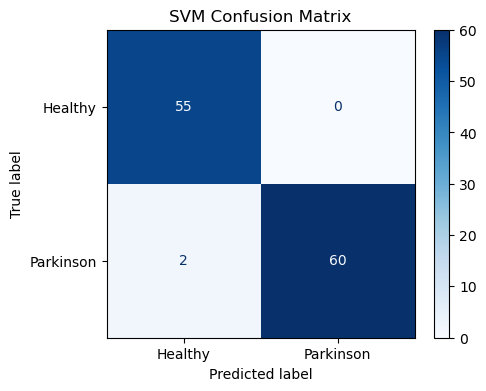

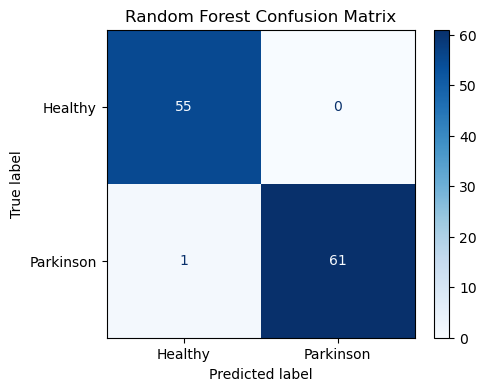

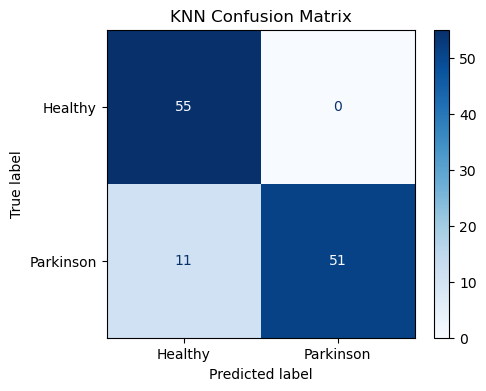

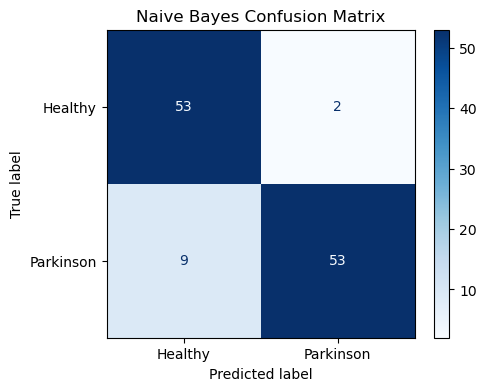

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Define models ---
models = {
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

# --- Train and evaluate ---
for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Parkinson"])
    
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax, cmap="Blues", values_format='d')
    plt.title(f"{name} Confusion Matrix")
    plt.show()


In [34]:
# --- Deep Learning Preparation ---
from sklearn.preprocessing import StandardScaler
import numpy as np

# --- Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)  # Fit on SMOTE-balanced training set
X_test_scaled = scaler.transform(X_test)           # Transform original test set


In [36]:
# --- Reshape for CNN+BiLSTM ---
timesteps = 10
feature_dim = X_train_scaled.shape[1] // timesteps

# Truncate features to match timesteps * feature_dim
X_train_dl = X_train_scaled[:, :timesteps*feature_dim].reshape((X_train_scaled.shape[0], timesteps, feature_dim))
X_test_dl = X_test_scaled[:, :timesteps*feature_dim].reshape((X_test_scaled.shape[0], timesteps, feature_dim))

print("DL input shapes - Train:", X_train_dl.shape, " | Test:", X_test_dl.shape)


DL input shapes - Train: (500, 10, 638)  | Test: (117, 10, 638)


In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', padding='same', input_shape=(timesteps, feature_dim)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),

    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),

    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3)),
    layers.Bidirectional(layers.LSTM(64, dropout=0.3)),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)




D:\jupyter\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
from sklearn.utils import class_weight

# --- Callbacks ---
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_bal),
    y=y_train_bal
)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}


In [44]:
history = model.fit(
    X_train_dl, y_train_bal,
    validation_data=(X_test_dl, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.4825 - loss: 1.3284 - val_accuracy: 0.4701 - val_loss: 1.0359 - learning_rate: 1.0000e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5482 - loss: 1.2202 - val_accuracy: 0.4701 - val_loss: 1.0346 - learning_rate: 1.0000e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5936 - loss: 1.1572 - val_accuracy: 0.4701 - val_loss: 1.0326 - learning_rate: 1.0000e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6358 - loss: 1.0203 - val_accuracy: 0.4701 - val_loss: 1.0274 - learning_rate: 1.0000e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7011 - loss: 0.9065 - val_accuracy: 0.4786 - val_loss: 1.0191 - learning_rate: 1.0000e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7388 - loss: 0.8737 - val_accuracy: 0.4786 - val_loss: 1.0085 - learning_rate: 1.0000e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy

In [46]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 10, 64)              │         122,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 5, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 5, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 2, 256)              │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,927,109 (7.35 MB)

 Trainable params: 641,985 (2.45 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 1,283,972 (4.90 MB)

In [48]:
# --- Predictions ---
y_pred_prob = model.predict(X_test_dl)
y_pred_dl = (y_pred_prob >= 0.5).astype(int).flatten()

# --- Metrics ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("CNN+BiLSTM Classification Report:\n", classification_report(y_test, y_pred_dl))


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step
CNN+BiLSTM Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95        55
           1       0.97      0.95      0.96        62

    accuracy                           0.96       117
   macro avg       0.96      0.96      0.96       117
weighted avg       0.96      0.96      0.96       117



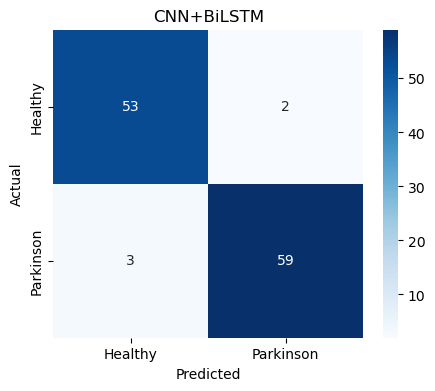

In [50]:
# --- Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Healthy", "Parkinson"],
                yticklabels=["Healthy", "Parkinson"])
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

plot_confusion_matrix(y_test, y_pred_dl, "CNN+BiLSTM")

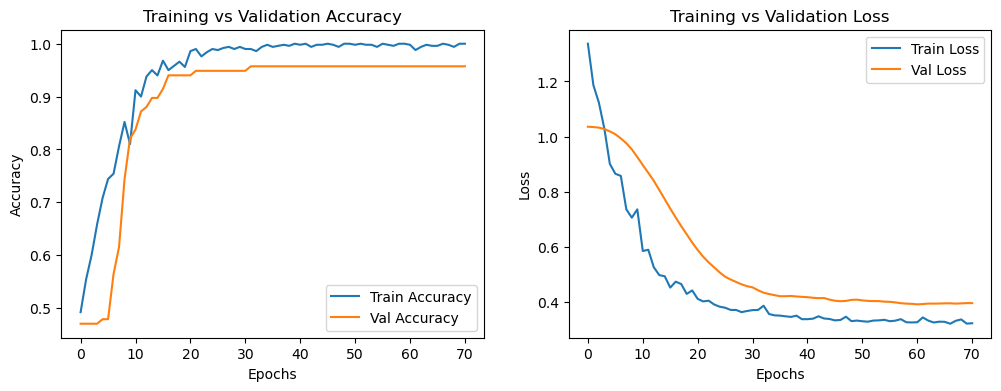

In [52]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


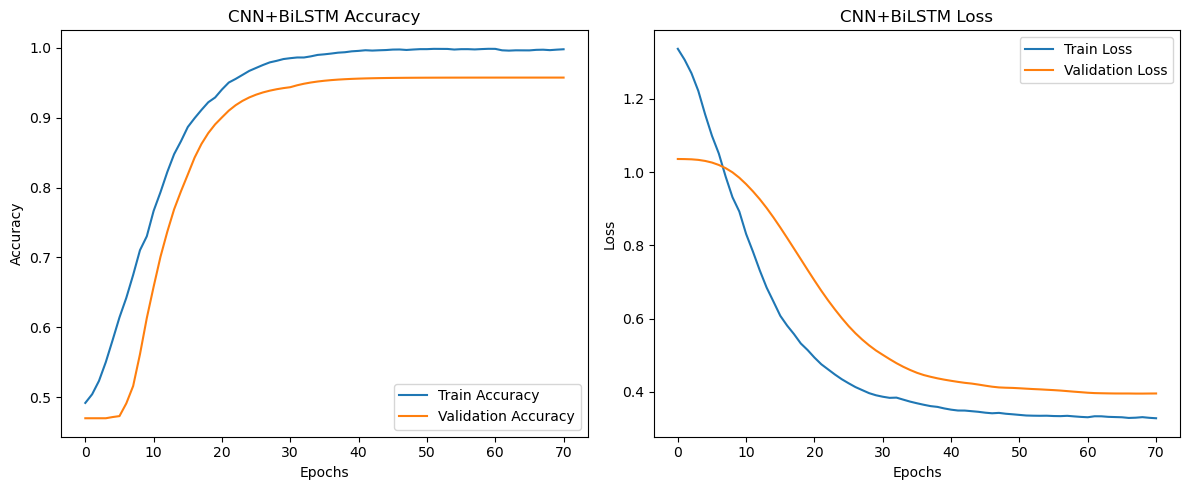

In [54]:
import matplotlib.pyplot as plt

# --- Smooth curves function ---
def smooth_curve(values, weight=0.8):
    smoothed = []
    last = values[0]
    for point in values:
        last = last * weight + (1 - weight) * point
        smoothed.append(last)
    return smoothed

# --- Smooth training curves ---
train_acc_smooth = smooth_curve(history.history['accuracy'])
val_acc_smooth = smooth_curve(history.history['val_accuracy'])
train_loss_smooth = smooth_curve(history.history['loss'])
val_loss_smooth = smooth_curve(history.history['val_loss'])

# --- Plot ---
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(train_acc_smooth, label='Train Accuracy')
plt.plot(val_acc_smooth, label='Validation Accuracy')
plt.title('CNN+BiLSTM Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Loss
plt.subplot(1,2,2)
plt.plot(train_loss_smooth, label='Train Loss')
plt.plot(val_loss_smooth, label='Validation Loss')
plt.title('CNN+BiLSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()


In [64]:
# --- Cell 18: Train and Evaluate Models on Hybrid Features ---

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# --- Define traditional ML models ---
models = {
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

# --- Train & evaluate traditional ML models ---
results = {}
predictions_hybrid = {}

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    predictions_hybrid[name] = y_pred
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = (acc, f1)

# --- Include CNN+BiLSTM predictions ---
predictions_hybrid["CNN+BiLSTM"] = y_pred_dl

# --- Comparison: Accuracy & F1-score ---
model_names = list(predictions_hybrid.keys())
accuracy = [accuracy_score(y_test, predictions_hybrid[name]) for name in model_names]
f1_scores = [f1_score(y_test, predictions_hybrid[name]) for name in model_names]

# --- Print results ---
for i, name in enumerate(model_names):
    print(f"{name} - Test Accuracy: {accuracy[i]:.4f}, F1-score: {f1_scores[i]:.4f}")



SVM - Test Accuracy: 0.9829, F1-score: 0.9836
Random Forest - Test Accuracy: 0.9915, F1-score: 0.9919
KNN - Test Accuracy: 0.9060, F1-score: 0.9027
Naive Bayes - Test Accuracy: 0.9060, F1-score: 0.9060
CNN+BiLSTM - Test Accuracy: 0.9573, F1-score: 0.9593


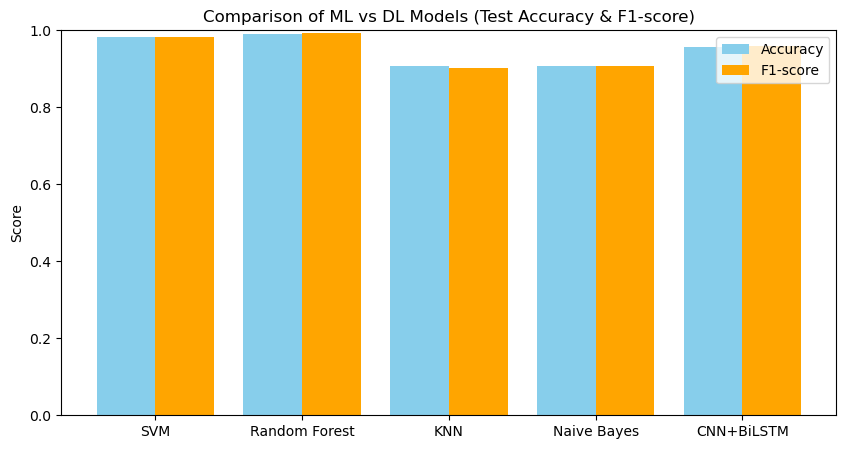

In [68]:
#  Plot comparison
import matplotlib.pyplot as plt
x = range(len(model_names))

plt.figure(figsize=(10,5))

# Accuracy bars
plt.bar(x, accuracy, width=0.4, label='Accuracy', color='skyblue', align='center')

# F1-score bars
plt.bar([i + 0.4 for i in x], f1_scores, width=0.4, label='F1-score', color='orange', align='center')

plt.xticks([i + 0.2 for i in x], model_names)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Comparison of ML vs DL Models (Test Accuracy & F1-score)')
plt.legend()
plt.show()